In [1]:
import numpy as np
from mp_api.client import MPRester
import re
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [2]:
#### Initialize training data
material_dset = pd.read_csv('material_dset_data.csv', header=None)
material_names = np.array(material_dset.iloc[:, 0])
material_calculation2 = np.array(material_dset.iloc[:,2])
material_alloydata = np.array(material_dset.iloc[:,3:43])
material_elements = np.array(material_dset.iloc[:,44:])
material_Tc = np.array(material_dset.iloc[:,43])

#           0         ,       1     ,     2       ,   3 - X      ,  X - last
# mainingredient_names, calculation1, calculation2, maincomp_data, all_comp
# mainingredient = ['Superconductor'] 
# calculation1 = ['Formation Energy of supercon']
# calculation2 = ['Weighted formation energy of likely oxides']

In [23]:
target = material_Tc
training_pre = np.column_stack((material_calculation2, material_elements))
training = np.where(training_pre == 0, 9999, training_pre)

In [24]:
# # Prepare your data and create DataLoader objects
# target_tensor = torch.Tensor(target)  # Convert your targets array to a PyTorch tensor
# data_tensor = torch.Tensor(training)  # Convert your data array to a PyTorch tensor

# # Normalize the data
# max_values = torch.max(data_tensor, dim=0).values
# data_tensor = data_tensor / max_values

# # Split the data into training and testing sets
# train_data, test_data, train_targets, test_targets = train_test_split(
#     data_tensor, target_tensor, test_size=0.25, random_state=42
# )
# train_dataset = TensorDataset(train_data, train_targets)
# test_dataset = TensorDataset(test_data, test_targets)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32)

# # Set the input size, hidden size, and output size according to your data
# input_size = 167  # Assuming your input data has 127 features
# hidden_size = 400  # Example value, replace with your desired hidden size
# output_size = 1  # Assuming you want to predict a single value


# # Define the MLP model
# class MLP(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, hidden_size)
#         self.fc3 = nn.Linear(hidden_size, output_size)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         x = self.relu(self.fc1(x))
#         x = self.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x


# # Create an instance of the MLP model
# model = MLP(input_size, hidden_size, output_size)

# # Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# # Training loop
# num_epochs = 100
# for epoch in range(num_epochs):
#     for inputs, labels in train_dataloader:
#         # Forward pass
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)

#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Print the loss after each epoch
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

# # After training, you can use the trained model for prediction
# # by passing new input data through the model's forward method


In [25]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare your data
data_array = training  # Assuming your data is in a NumPy array
target_array = target  # Assuming your targets are in a NumPy array

# Split the data into training and testing sets
train_data, test_data, train_targets, test_targets = train_test_split(
    data_array, target_array, test_size=0.20, random_state=31
)

# Create the DMatrix for XGBoost
dtrain = xgb.DMatrix(train_data, label=train_targets)
dtest = xgb.DMatrix(test_data, label=test_targets)

# Set the XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Objective function for regression
    'eval_metric': 'rmse',  # Evaluation metric for regression
    'max_depth': 16,  # Maximum depth of each tree
    'min_child_weight': 1,
    'colsample_bytree': 0.50,
    'learning_rate': 0.02,  # Learning rate
    'n_estimators': 375  # Number of trees (boosting rounds)
}

# Train the XGBoost model
model = xgb.train(params, dtrain, num_boost_round=150)

# Make predictions on the test set
predictions = model.predict(dtest)

# Calculate the root mean squared error (RMSE)
rmse = mean_squared_error(test_targets, predictions, squared=False)
print(f"Root Mean Squared Error (RMSE): {rmse}")


[17:10:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.

Root Mean Squared Error (RMSE): 9.734036141333828


Text(0, 0.5, 'True Tc')

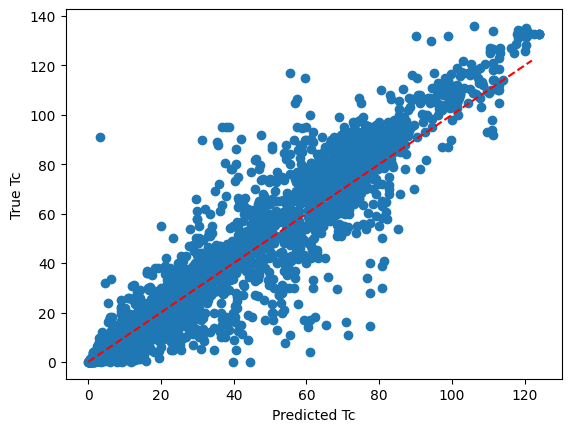

In [26]:
plt.scatter(predictions, test_targets)
x_values = range(0, int(max(predictions)))
plt.plot(x_values, x_values, 'r--')  # 'r--' sets red dashed line style

plt.xlabel('Predicted Tc')
plt.ylabel('True Tc')

In [27]:
####
realizedalloys_dset = pd.read_csv('realizedalloys_dset_data.csv', header=None)
realizedalloys_names = np.array(realizedalloys_dset.iloc[:, 0])
realizedalloys_calculation2 = np.array(realizedalloys_dset.iloc[:,2])
realizedalloys_alloydata = np.array(realizedalloys_dset.iloc[:,3:43])
realizedalloys_elements = np.array(realizedalloys_dset.iloc[:,44:])
realizedalloys_Tc = np.array(realizedalloys_dset.iloc[:,43])

target_realized = realizedalloys_Tc
training_realized_pre = np.column_stack((realizedalloys_calculation2, realizedalloys_elements))
training_realized = np.where(training_realized_pre == 0, 9999, training_realized_pre)


realized_dtest = xgb.DMatrix(training_realized, label=target_realized)
realized_predictedTc = model.predict(realized_dtest)

In [28]:
possiblealloys_dset = pd.read_csv('possiblealloys_dset_data.csv', header=None)
possiblealloys_names = np.array(possiblealloys_dset.iloc[:, 0])
possiblealloys_calculation2 = np.array(possiblealloys_dset.iloc[:,2])
possiblealloys_alloydata = np.array(possiblealloys_dset.iloc[:,3:43])
possiblealloys_elements = np.array(possiblealloys_dset.iloc[:,44:])
possiblealloys_Tc = np.array(possiblealloys_dset.iloc[:,43])

target_possible = possiblealloys_Tc
training_possible_pre = np.column_stack((possiblealloys_calculation2, possiblealloys_elements))
training_possible = np.where(training_possible_pre == 0, 9999, training_possible_pre)


possible_dtest = xgb.DMatrix(training_possible, label=target_possible)
possible_predictedTc = model.predict(possible_dtest)

Text(0, 0.5, 'Realized Alloys Predicted Tc')

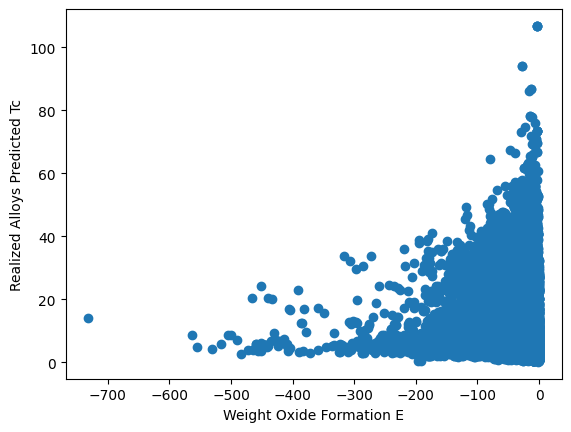

In [29]:
plt.scatter(realizedalloys_calculation2, realized_predictedTc)
plt.xlabel('Weight Oxide Formation E')
plt.ylabel('Realized Alloys Predicted Tc')

Text(0, 0.5, 'Possible Alloys Predicted Tc')

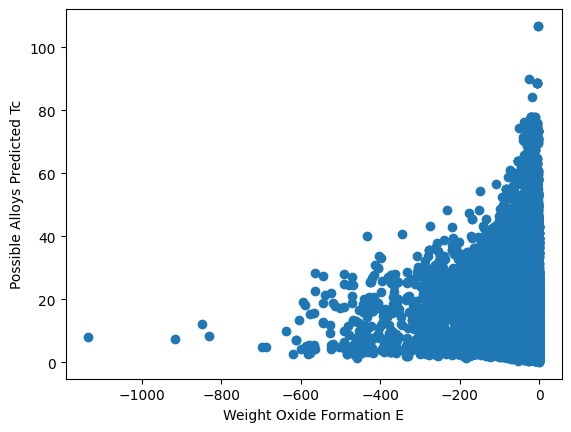

In [30]:
plt.scatter(possiblealloys_calculation2, possible_predictedTc)
plt.xlabel('Weight Oxide Formation E')
plt.ylabel('Possible Alloys Predicted Tc')

In [32]:
np.savetxt('realizedalloys_dset_Tc.csv', realized_predictedTc, delimiter=',',fmt='%s')
np.savetxt('possiblealloys_dset_Tc.csv', possible_predictedTc, delimiter=',',fmt='%s')


In [33]:
index = np.where(realizedalloys_names == 'Ti1.0N1.0')
realized_predictedTc[39885]

5.244332